#                                     ** ** PLEASE NOTE** **

If you plan to re-run cells, please pip install or (through other means) install the necessary packages locally:
- spotipy, nltk, textblob, vaderSentiment, lyricsgenius

The cell below shows an example:


In [10]:
pip install vaderSentiment

  Using cached https://files.pythonhosted.org/packages/76/fc/310e16254683c1ed35eeb97386986d6c00bc29df17ce280aed64d55537e9/vaderSentiment-3.3.2-py2.py3-none-any.whl
You are using pip version 9.0.3, however version 20.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [29]:
#necessary packages for querying data:
import sys
import lyricsgenius as genius
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import re
import json

#other packages for data preprocessing/analysis
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#plotting 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
#sns.set_context("talk")

[nltk_data] Downloading package stopwords to /opt/conda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Table of Contents:
* [Introduction](#intro)
* [Data Gathering](#dgather)
* [Data Summary and Cleaning](#dsummary)
* [Sentiment Analysis](#sent)
* [Data Visualization](#dviz)
* [Statistical Testing](#stat)
* [Spotify Analysis](#spotify)
* [Conclusion](#conc)

## Introduction <a class="anchor" id="intro"></a>

#### Who is Frank Ocean?

Christopher Edwin Breaux, or by his moniker Frank Ocean, is an award-winning American singer-songwriter who has released multiple projects, with Blonde being his most recent release. He has advanced the genre of R&B with his unconvential production and experimental approach of infusing multiple genres like jazz,funk, soul, psychedelic rock, and even hip-hop to his music.

#### What is this project about?
I find it fascinating that we have access to a whole artist's discography-- it provides access for us fans to compare songs throughout different phases of the artist's career. I want to capture if there are recognizable patterns in Frank Ocean's discography, namely, analyzing his songwriting under a lingustic lens. By running sentiment analsyis on his lyrics, I hope to confirm my prior biases that his albums get more negative over time (with Nostalgia, Ultra. being his "most positive" and with time, Blonde being his most "negative" album. And if possible, I want to compare my findings with the attributes that Spotify provides (which includes musical valence) to see if the instrumentation match the lyrics.

Due to my time being rather limited and since I am P/NP'ing this class -- I won't be able to do as much as I want to do for this project. So if it seems rather sparse, I plan to continue this project on my free time so I can share it online.

## Data Gathering<a class="anchor" id="dgather"></a>

The following is the custom script to extract the data from both Spotify and Genius's API. I wanted to make it as general as possible so I can create a dataset for any artist I want (for future analysis, and potentially for others to use it). It first gathers what is necesssary for the Spotify attributes and exports it into a json file -- which is then read into a pandas dataframe. The lyrics from Genius are a lot easier to get as we just export everything into a dataframe through a .csv file that is read much later.

In [ ]:
#Accesing Spotify's API through Spotipy, a custom wrapper to access Spotify's API.

#PLEASE DO NOT SHARE CODE WITHOUT MY PERMISSION (has personal info for auth):

client_credentials_manager = SpotifyClientCredentials(client_id='911b425bc8c3496297b0a66d3df0b236', client_secret='5f581823761649768f3ca1d3a7cfc6de')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [7]:
#Unfortunately can not run in datahub, has to be ran locally through an IDE of some sort or terminal.
while True:
    print()
    print(">>> Welcome to Build Your Own Spotify/Lyrics Dataset!")
    print()
    print("0 - Create csv for an artist's songs/audio features")
    print("1 - Find lyrics for an artist")
    print("2 - Exit")
    print()
    choice = input("Your choice: ")

    if choice == "0":
        print()
        searchQuery = input("Ok, what's their name?: ")
        print()

        # Get search results
        searchResults = spotify.search(searchQuery,1,0,"artist")
        # Artist details
        artist = searchResults['artists']['items'][0]
        artist_name = artist['name']
        print(artist['name'])
        print(str(artist['followers']['total']) + " followers")
        print(artist['genres'][0])
        artist_id = artist['id'] #2h93pZq0e7k5yf4dywlkpM for Frank Ocean

        #artistURI(id) = 'spotify:artist:2h93pZq0e7k5yf4dywlkpM'

        albums = spotify.artist_albums(artist_id, country="US", limit=50)
        album_ids = [album['uri'] for album in albums['items']]
        print(artist_name + ' has ' + str(len(album_ids)) + ' albums (on spotify, might be singles)!')

        all_tracks = []
        for album_id in album_ids:
            tracks = spotify.album_tracks(album_id, limit=50)
            all_tracks.append(tracks)

        #Prints how many tracks per album on the left
        #all tracks, lists per album tracks, and the keys for the albums
        for tracks, album in zip(all_tracks, albums.get('items')):
            print(
                len(tracks.get('items')),
                "\t",
                album.get('name'))

        #Now getting each track id or uri to get features
        track_ids = []
        for tracks in all_tracks:
            album_tracks = []
            for track in tracks.get('items'):
                album_tracks.append(track.get('uri'))
            track_ids.append(album_tracks)

        #now grouping each track to album
        track_objects = []
        for track_id_list in track_ids:
            tracks = spotify.tracks(track_id_list)
            track_objects.append(tracks)

        #grabbing audio features for each track
        audio_feature_objects = []
        for track_id_list in track_ids:
            features = spotify.audio_features(track_id_list)
            audio_feature_objects.append(features)

        #create dictionary for json file
        spotify_data = {
            "audio_features": audio_feature_objects,
            "tracks": track_objects}

        with open('spotify.json', 'w') as outfile:
            json.dump(spotify_data, outfile) ##dumps file locally into a jason file

        df = pd.DataFrame(columns=[
            'name',
            'duration_ms',
            'popularity',
            'num_markets',
            'album',
            'disc_number',
            'is_explicit',
            'track_number',
            'release_date',
            'artist',
            'danceability',
            'energy',
            'key',
            'loudness',
            'mode',
            'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'tempo',
            'time_signature',
        ])
        for album_info, album_features in zip(
                spotify_data.get('tracks'),
                spotify_data.get('audio_features')):
            for track_info, track_features in zip(
                album_info.get('tracks'), album_features):
                y = {
                    'name': track_info['name'],
                    'duration_ms': track_info['duration_ms'],
                    'popularity': track_info['popularity'],
                    'num_markets': len(track_info['available_markets']),
                    'album': track_info['album']['name'],
                    'disc_number': track_info['disc_number'],
                    'is_explicit': track_info['explicit'],
                    'track_number': track_info['track_number'],
                    'release_date': track_info['album']['release_date'],
                    'artist': track_info['artists'][0]['name'],
                    'danceability': track_features['danceability'],
                    'energy': track_features['energy'],
                    'key': track_features['key'],
                    'loudness': track_features['loudness'],
                    'mode': track_features['mode'],
                    'speechiness': track_features['speechiness'],
                    'acousticness': track_features['acousticness'],
                    'instrumentalness': track_features['instrumentalness'],
                    'liveness': track_features['liveness'],
                    'valence': track_features['valence'],
                    'tempo': track_features['tempo'],
                    'time_signature': track_features['time_signature'],
                }
                df = df.append(y, ignore_index=True)
        df.to_csv("spotify.csv", index=False)
        print(df.iloc[0])

    if choice == "1":
        print()
        searchQuery2 = input("Extract Lyrics from which Artist? :")
        print()

        #Create Lyrics CSV
        import lyricsgenius as genius
        api = genius.Genius('tZhiB5ALt1qhLTWHtY_onJBHr4rLvRoFHvE8h5xSii24WJ8ioc9_-DxyuQzGbYtS') #auth code
        artist2 = api.search_artist(searchQuery2)
        genius_songs = artist2.songs
        lyric_df = pd.DataFrame(columns=['title', 'album', 'year','lyrics'])
        for x in genius_songs:
            lyric_df = lyric_df.append({
                'title': x.title,
                'lyrics': x.lyrics,
                'album': x.album,
                'year': x.year
            }, ignore_index=True)
        lyric_df.to_csv("lyric.csv", index=False)
        print()
        print("Lyrics saved!")

    if choice == "2":
        break


>>> Welcome to Build Your Own Spotify/Lyrics Dataset!

0 - Create csv for an artist's songs/audio features
1 - Find lyrics for an artist
2 - Exit

Your choice: 1

Extract Lyrics from which Artist? :Frank Ocean

Searching for songs by Frank Ocean...

Song 1: "Thinkin Bout You"
Song 2: "Nights"
Song 3: "Pink Matter"
Song 4: "Chanel"
Song 5: "Self Control"
Song 6: "Pyramids"
Song 7: "Ivy"
Song 8: "Super Rich Kids"
Song 9: "Nikes"
Song 10: "Lost"
Song 11: "Bad Religion"
Song 12: "Novacane"
Song 13: "Pink + White"
Song 14: "Forrest Gump"
Song 15: "White Ferrari"
Song 16: "Solo"
Song 17: "Swim Good"
Song 18: "Seigfried"
Song 19: "Biking"
Song 20: "Solo (Reprise)"
Song 21: "Sweet Life"
Song 22: "Futura Free"
Song 23: "Godspeed"
Song 24: "Pilot Jones"
Song 25: "DHL"
Song 26: "Skyline To"
Song 27: "We All Try"
Song 28: "Crack Rock"
Song 29: "Cayendo"
Song 30: "Sierra Leone"
Song 31: "Close to You"
Song 32: "Good Guy"
Song 33: "In My Room"
Song 34: "Frank Ocean’s Open Letter on Tumblr"
Song 35:

TypeError: argument of type 'NoneType' is not iterable

## Data Summary and Cleaning<a class="anchor" id="dsummary"></a>

### Data Summary:

`songs.csv` is a .csv file that contains multiple attributes that Spotify provides for each song uploaded to their platform. More information about how these audio features are recorded by Spotify can be found here:
https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/

What is interesting though that some of these features are similar in lingustics, namely, '`speechiness`, and `loudness` can be attributed to how the singer sings the song. Given that I do not really have much lingustics background, I plan to focus on `valence` which describes the musical positiveness conveyed by a track. As noted by Spotify's API: 

`Tracks with high valence sound more positive (happy, cheerful, euphoric), while tracks with low valence sound more negative (sad, depressed, angry).`

In [53]:
songs = pd.read_csv("frank_spotify.csv")
songs.head()

,name,duration_ms,popularity,num_markets,album,disc_number,is_explicit,track_number,release_date,artist,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Nikes,314075,73,79,Blonde,1,True,1,2016-08-20,Frank Ocean,...,8,-9.637,1,0.0864,0.695,0.000239,0.108,0.118,137.811,4
1,Ivy,249191,77,79,Blonde,1,True,2,2016-08-20,Frank Ocean,...,9,-9.579,0,0.0384,0.782,0.000309,0.248,0.452,116.362,4
2,Pink + White,184516,78,79,Blonde,1,False,3,2016-08-20,Frank Ocean,...,9,-7.450,1,0.0991,0.670,0.000046,0.415,0.554,159.738,3
3,Be Yourself,86943,62,79,Blonde,1,False,4,2016-08-20,Frank Ocean,...,7,-11.147,1,0.5410,0.985,0.000000,0.149,0.935,83.509,3
4,Solo,257380,71,79,Blonde,1,True,5,2016-08-20,Frank Ocean,...,5,-10.631,0,0.0375,0.849,0.000003,0.161,0.246,124.027,4


 Note that we have 421 songs which is quite a lot -- a lot of them are features or songs attributed to Frank Ocean. We plan to prune these datapoints so we can focus on Frank's albums he has produced only.

In [54]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 22 columns):
name                421 non-null object
duration_ms         421 non-null int64
popularity          421 non-null int64
num_markets         421 non-null int64
album               421 non-null object
disc_number         421 non-null int64
is_explicit         421 non-null bool
track_number        421 non-null int64
release_date        421 non-null object
artist              421 non-null object
danceability        421 non-null float64
energy              421 non-null float64
key                 421 non-null int64
loudness            421 non-null float64
mode                421 non-null int64
speechiness         421 non-null float64
acousticness        421 non-null float64
instrumentalness    421 non-null float64
liveness            421 non-null float64
valence             421 non-null float64
tempo               421 non-null float64
time_signature      421 non-null int64
dtypes: bool(1),

We can see this is true by looking at what albums are included:

In [55]:
songs['album'].unique()

array(['Blonde', 'channel ORANGE', 'Moon River', 'Provider',
       'Biking (Solo)', 'Lens', 'Biking', 'Chanel', 'Thinkin Bout You',
       'Novacane', 'Swim Good', "New Year's Eve - NYE 2018/2019",
       'TESTING', "New Year's Eve 2017/18", 'Cozy Tapes Vol. 2: Too Cozy',
       "NOW That's What I Call Music, Vol. 63", 'Flower Boy',
       'Funk Wav Bounces Vol.1', 'Who Dat Boy / 911', 'RAF',
       'Slide (feat. Frank Ocean & Migos)', 'BEYONCÉ [Platinum Edition]',
       'Doris', 'Paradise Valley', 'Wolf',
       "Music From Baz Luhrmann's Film The Great Gatsby (Deluxe Edition)",
       'The Bling Ring: Original Motion Picture Soundtrack', 'Numbers',
       'The OF Tape Vol. 2', '12 Odd Future Songs', 'Blackenedwhite'],
      dtype=object)

In [56]:
songs.describe()

,duration_ms,popularity,num_markets,disc_number,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,221907.408551,39.921615,72.244656,1.028504,9.413302,0.614268,0.608629,4.817102,-7.886770,0.591449,0.181919,0.264456,0.042989,0.220817,0.451928,114.878392,3.893112
std,76187.441522,21.027103,22.117855,0.166604,6.670847,0.174437,0.196578,3.773629,3.488793,0.492151,0.149562,0.275776,0.168578,0.173865,0.236179,29.570818,0.613712
min,7546.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.005620,0.000000,-32.353000,0.000000,0.000000,0.000053,0.000000,0.000000,0.000000,0.000000,0.000000
25%,187786.000000,24.000000,79.000000,1.000000,4.000000,0.511000,0.485000,1.000000,-9.534000,0.000000,0.057100,0.045000,0.000000,0.104000,0.274000,91.783000,4.000000
50%,214880.000000,38.000000,79.000000,1.000000,8.000000,0.626000,0.626000,5.000000,-7.239000,1.000000,0.126000,0.150000,0.000002,0.146000,0.457000,120.041000,4.000000
75%,250373.000000,59.000000,79.000000,1.000000,13.000000,0.733000,0.760000,8.000000,-5.606000,1.000000,0.286000,0.440000,0.000711,0.304000,0.607000,136.275000,4.000000
max,636213.000000,86.000000,79.000000,2.000000,34.000000,0.982000,0.975000,11.000000,-2.261000,1.000000,0.933000,0.985000,0.979000,0.890000,0.981000,195.956000,5.000000


As we see below, there is a lot of data cleaning that needs to take place. Some album names are missing, and a lot of regex must be used to remove the white space/escape characters. Additionally, Genius includes segment blocks to indicate if it's the verses and chourses, so removing uneccessary stuff is mandatory for doing sentiment analysis. Lastly, some songs are instrumental so we want to manually remove those points as well.

In [57]:
lyrics = pd.read_csv("frank_lyric.csv")
lyrics = lyrics[['title', 'album','lyrics',]]
lyrics.head()

,title,album,lyrics
0,4 Tears,NaN,"Swag, swag times two\r\n\r\nI don't cry cause ..."
1,Abracadabra,NaN,[Verse 1]\r\nI don't wanna be the reason we do...
2,A Certain Way,Endless,In a certain way\r\n'Cause you are beautiful a...
3,Acura Integurl,The Lonny Breaux Collection,"[Verse 1]\r\nShe singing, ""Bitch, I'm paid, th..."
4,Alabama,Endless,"[Verse: Frank Ocean]\r\nYup, duplex in New Orl..."


In [58]:
lyrics.info() #we see that a lot of albums are missing, and some are just instrumentals.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 3 columns):
title     271 non-null object
album     187 non-null object
lyrics    264 non-null object
dtypes: object(3)
memory usage: 6.4+ KB


### Now onto some Data Cleaning:

Let's first update the songs we want to specified albums and singles found below:

Unfortunately, `nostalgia, ULTRA.` is not on Spotify so only the singles, Swim Good and Novacane will be analyzed.

In [59]:
song_albums = [
    'Blonde', 'channel ORANGE', 'Moon River', 'Provider',
    'Biking (Solo)', 'Lens', 'Chanel', 'Slide (feat. Frank Ocean & Migos)', 'RAF', 'Novacane', 'Swim Good',
    'Thinkin Bout You', 'Chanel'
]

songs_updated = songs.loc[songs['album'].isin(song_albums)]
songs_updated.head()

,name,duration_ms,popularity,num_markets,album,disc_number,is_explicit,track_number,release_date,artist,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Nikes,314075,73,79,Blonde,1,True,1,2016-08-20,Frank Ocean,...,8,-9.637,1,0.0864,0.695,0.000239,0.108,0.118,137.811,4
1,Ivy,249191,77,79,Blonde,1,True,2,2016-08-20,Frank Ocean,...,9,-9.579,0,0.0384,0.782,0.000309,0.248,0.452,116.362,4
2,Pink + White,184516,78,79,Blonde,1,False,3,2016-08-20,Frank Ocean,...,9,-7.450,1,0.0991,0.670,0.000046,0.415,0.554,159.738,3
3,Be Yourself,86943,62,79,Blonde,1,False,4,2016-08-20,Frank Ocean,...,7,-11.147,1,0.5410,0.985,0.000000,0.149,0.935,83.509,3
4,Solo,257380,71,79,Blonde,1,True,5,2016-08-20,Frank Ocean,...,5,-10.631,0,0.0375,0.849,0.000003,0.161,0.246,124.027,4


Now there's only `46` songs to analyze:

In [60]:
len(songs_updated)

46

There's redudancy in some singles we have to remove (Novacane Edited and Nonexplicit RAF):

In [61]:
songs_updated = songs_updated.drop(42) #Novacane Edited
songs_updated = songs_updated.drop(220) #Nonexplicit RAF
len(songs_updated)

44

In [62]:
lyrics['album'].unique() #before data cleaning

array([nan, 'Endless', 'The Lonny Breaux Collection ',
       'blonded RADIO Tracklists, Skits, and Interviews',
       'nostalgia, ULTRA.', 'Frank Ocean: Tumblr', 'channel ORANGE',
       'Blonde ', "Boys Don't Cry (Magazine)",
       'Blonde (Magazine Version)',
       'Southpaw (Music From And Inspired by the Motion Picture)'],
      dtype=object)

Now let's do the same datacleaning to filter the `lyrics.csv` to the albums/singles we want:

In [63]:
lyric_albums = ['nostalgia, ULTRA.', 'channel ORANGE', 'Blonde ', 'Endless']
selected_titles = ['Moon River', 'Chanel', 'Summer Remains', 'Lens', 'Provider', 'Biking (Solo)']

lyrics_updated = lyrics.loc[lyrics['album'].isin(lyric_albums) | lyrics['title'].isin(selected_titles)]
len(lyrics_updated)

#Titles do not match:
lyrics_updated = lyrics_updated.replace("Close to You", "Close To You")
lyrics_updated = lyrics_updated.replace("End/Golden Girl", "End")
#lyrics_updated[lyrics_updated['title'] == 'Nostalgia, ULTRA [Artwork]'] = 143
lyrics_updated = lyrics_updated.drop(143)

This is the most complicated part is filtering which information we actually need. The following describes what the below block does:

1. Make the dataframe more readable by dropping album name as a column (as we are merging with songs later by Title).
2. Remove stopwords from lyrics; we are using nltk (please make sure `nltk.download('stopwords')` is ran so you have access to the list of stopwords used. We want to count how many stopwords are removed to see how much words are removed from the original lyrics.
3. Remove unecessary segments: `(Verse [0-9]|Pre-Chorus [0-9]|Hook [0-9]|Chorus|Outro|Verse|Refrain|Hook|Bridge|Intro|Instrumental|Skit)`
4. Remove punctuation from the words.
5. Remove the Japanese lyrics from one of the songs in Blonde.

In [64]:
#Pre-Processing of Lyrics:

# Ensure that Pandas shows at least 500 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 1250)

#Altering the lyrics to make it more readable:
test_lyrics = lyrics_updated[['title','lyrics']]

test_lyrics.loc[:,'lyrics'] = test_lyrics['lyrics'].str.lower()
stop = stopwords.words('english')
stop += ['i\'ll']
#count stopwords
test_lyrics.loc[:,'stopwords'] = test_lyrics['lyrics'].apply(lambda x: len([x for x in x.split() if x in stop]))

#Pre-processing continued:

test_lyrics.loc[:,'lyrics'] = test_lyrics['lyrics'].str.replace('\[(.*)]', '') #removes the following:
#(Verse [0-9]|Pre-Chorus [0-9]|Hook [0-9]|Chorus|Outro|Verse|Refrain|Hook|Bridge|Intro|Instrumental|Skit)
#removes stop words
test_lyrics.loc[:,'lyrics'] = test_lyrics['lyrics'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
test_lyrics.head()
#remove punctuation
test_lyrics.loc[:,'lyrics'] = test_lyrics['lyrics'].str.replace('[^\w\s]', '') #removes punctuation
test_lyrics.loc[:,'lyrics'] = test_lyrics['lyrics'].str.replace('\r\n', ' ') 

#remove japanese verse from solo
test_lyrics.loc[:,'lyrics'] = test_lyrics['lyrics'].str.replace('一(.*)','')
test_lyrics.head(3)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,title,lyrics,stopwords
2,A Certain Way,certain way cause beautiful young deserve best life certain way,14
4,Alabama,yup duplex new orleans east writin everything things would tell nobody things even tell sleepin back body would wake barber fresh penitentiary alcohol stingin four cousins stayed me stayed us one shower aunt law come fuss fight get cutoffs wifebeater barefeet braless titties swingin seventeen vaseline reebok classics take bully greenest grasses name renny cool matthew pairs air maxes clarky road rashes lost virgin air mattress texturizer feelin unnatural would show special could know better now love now know better show love know better do do,111
6,American Wedding,american love american me american american tear american heartbreak oh oh oh took walk palm trees daylight fell sangria canteen talking i cant remember tattoo left hand turning purpleish blue daydreams romance daydreams pretty woman ballgown im richard gere tux getting married courthouse writing vows rush making judge teenage wife got wedding band done might die american wedding mean much love american wedding whats mine yours thats american law mrs dot kennedy signed name pen fancy fancy cursive turned term papers thesis islamic virgin brides arranged marriage hijabs polygamist husbands poor unamerican girls school ran me jumped 50 home brave land free parents still know said ive hell summer so baby take hard maybe get annulment goes way far american wedding mean much last enough american wedding whats mine yours american divorce well mustang thats ive got name jesus christ break heart wedding ring ever wipe stay oh stay probably leave later anyway love made usa let em front saying cant move without em fuck em tell em aint new hustlers since began dude aint gon tripping bitchass dude vain tell em aint get sensitive shit aint true niggas cant nothing cant cant do cant cant do cant man dream shit came true nigga it think nigga...,214


As expected, longer songs tend to have more stopwords, while songs with just instrumentals were not altered much.

In [65]:
test_lyrics.sort_values('stopwords', ascending = False).head(5)

,title,lyrics,stopwords
65,Futura Free,alright hold honest id say long could fuck three times day skip meal im good used work feet 7 dollars hour call momma like momma aint making minimum wage momma im momma im im making 400 600 800k momma stand feet momma play songs therapy momma paying me momma paying paying yall honest god im guy im god sometimes feel like im god im god know heaven would momma let run bitch ima run ground momma whole galaxy god damn fuck lames want none fuck lames want none fuck niggas fuck niggas want none fuck niggas fuck niggas fuck hated ima stick around im gon let nuts hang nigga got like you maybe like know im africano americano even half japanese roots run deep family tree throw big shadow jamming rhythm tech company please gimme immortality its face face im going rapidly fading drastically keep high castrati punani fade stress pull zip wet lips first lick tip bugatti left stretch marks freeway smoke somen marks freeway tryna find 2pac let em find 2pac evade press escape stress la da da da da la da da da da la da da da da la da da da da keep quiet let run phone bill know love talk aint schedule aint schedule aint job since 2009 aint sales floor say im changing feel like selena wanna murder nigga murder like selena must aint get memo cut b...,383
135,Nights,round city round clock everybody needs no cant make everybody equal although got beaucoup family even got nobody honest breathe til evaporated whole body see transportation handmade g know better people trust em anyways cant break law get gushy calm night shooters killing left right working worst night get money right know need tell you bitch hope sack full im fuckin im fucked spend get aint tryna keep cant keep conversation cant nobody reach eyes well up call séance past life hope well bruh head first always like head first signal coming hope well bruh everybody needs you everybody needs oooh nani nani feel like quaalude sleep body aint bitch body new beginnings ahh new beginnings wake akh suns going time start day bruh cant keep laid know need money gon survive every night shit every day shit dropping baby home night shift know cant hear none spend night shit kumbaya shit wanna see nirvana want die yet wanna feel na na though could come by fuck shift know boys wanna see broke shit bummed shit stressed shit thats every day shit shut fuck dont want conversation rolling marijuana thats cheap vacation every day shit every night shit every day shit every night shit night shit night shit night shit night ready night waiting night ...,260
51,End,darker times theyre telling boulder heavy lies looks like weve got truth obsolete remember mother didnt compromise could recognize voodoo daughters sons candles sun voodoo dont let see divide dont let see divide voodoo shes got whole wide world juicy fruit hes got whole wide world pants wrapped whole wide world wedding band put whole wide world hands shes got whole wide world hands hes got whole wide world hands theres somethin cant believe im even talking you tellin right special wish could see see peels orange us morning woke give half hear children soccer ballin like wildcats running grass hey girl island im boy america flight leaves tonight think im going backwards going backwards golden girl one ive chosen girl 24k make bright grey golden girl sun kind 24k girl skys never grey never grey silent moments meditative poses break focus make laugh two mopeds racing forest making dirt clouds path path im best island im mess america flight left last night know im going back home yeah im going back home golden girl one ive chosen girl 24k make bright grey golden girl sun kind 24k girl skys never grey never grey build house paradise get heaven still tropic tropic tropic breezes breezes breezes live hell get heaven tropic tropic tro...,255
168,Pyramids,set cheetahs loose theres thief move underneath legions view taken cleopatra run run run come back glory bring back run run run crown pharaoh throne queen empty well ru

## Sentiment Analysis<a class="anchor" id="sent"></a>

I was told to cite this paper if I plan to use vaderSentiment, a lexicon rule-based sentiment analysis tool that is mainly used for sentiments expressed in social media. I thought that using VADER was appropriate since a lot of lyrics from Frank has lingo that can be found through social media, that is not captured by a lot of other lexicon systems.

`Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.`

We plan to apply the given functions calculate polarity scores of all positive, neutral, and negative sentiments of the lyrics -- rather than a final sentiment score that most lexicon systems use. VADER then provides a compunded score, computed by "summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive)."

The normalizing factor is found below for thecompound score:

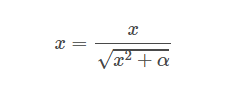

We calculate valenceDiff -- which is just the Spotify Valence minus the vader compound score calculated by VADER.

In [66]:
#Vader Analysis:

sent_vader = SentimentIntensityAnalyzer()

test_lyrics.loc[:,'vaderPos'] = test_lyrics['lyrics'].apply(lambda x: sent_vader.polarity_scores(x)['pos'])
test_lyrics.loc[:,'vaderNeu'] = test_lyrics['lyrics'].apply(lambda x: sent_vader.polarity_scores(x)['neu'])
test_lyrics.loc[:,'vaderNeg'] = test_lyrics['lyrics'].apply(lambda x: sent_vader.polarity_scores(x)['neg'])
test_lyrics.loc[:,'vaderCombined'] = test_lyrics['lyrics'].apply(lambda x: sent_vader.polarity_scores(x)['compound'])

final_lyrics = test_lyrics.loc[:]
final_lyrics.head(3)

#MERGING BOTH CSV's
frank = songs_updated.merge(right = final_lyrics, how = 'inner', left_on = 'name', right_on = 'title') 

#difference between valences (SPOTIFY - VADER)
frank['valenceDiff'] = (frank['valence'] - frank['vaderCombined'])

#can't do outer join or else RAF,Slide, and Endless do not have lyrics or song features.
pd.set_option('max_colwidth', 50)

In [67]:
frank.head(3)

,name,duration_ms,popularity,num_markets,album,disc_number,is_explicit,track_number,release_date,artist,...,tempo,time_signature,title,lyrics,stopwords,vaderPos,vaderNeu,vaderNeg,vaderCombined,valenceDiff
0,Nikes,314075,73,79,Blonde,1,True,1,2016-08-20,Frank Ocean,...,137.811,4,Nikes,bitches want nikes looking check tell em aint ...,179,0.264,0.654,0.082,0.9908,-0.8728
1,Ivy,249191,77,79,Blonde,1,True,2,2016-08-20,Frank Ocean,...,116.362,4,Ivy,thought dreaming said loved start nothing chan...,199,0.252,0.554,0.194,0.9042,-0.4522
2,Pink + White,184516,78,79,Blonde,1,False,3,2016-08-20,Frank Ocean,...,159.738,3,Pink + White,yeah yeah woo yeah yeah yeah thats way every d...,140,0.270,0.643,0.088,0.9860,-0.4320


In [68]:
#remove unnecessary columns
frank = frank.drop(['title','artist','disc_number'], axis = 1)
#Change Index to Title of Track
frank = frank.set_index('name')
#Change Labeling due to Merging
final_frank = frank.rename(columns = lambda x:'album' if x == 'album_x' else x)
final_frank = final_frank.reset_index()
final_frank.head(3)

,name,duration_ms,popularity,num_markets,album,is_explicit,track_number,release_date,danceability,energy,...,valence,tempo,time_signature,lyrics,stopwords,vaderPos,vaderNeu,vaderNeg,vaderCombined,valenceDiff
0,Nikes,314075,73,79,Blonde,True,1,2016-08-20,0.543,0.394,...,0.118,137.811,4,bitches want nikes looking check tell em aint ...,179,0.264,0.654,0.082,0.9908,-0.8728
1,Ivy,249191,77,79,Blonde,True,2,2016-08-20,0.567,0.388,...,0.452,116.362,4,thought dreaming said loved start nothing chan...,199,0.252,0.554,0.194,0.9042,-0.4522
2,Pink + White,184516,78,79,Blonde,False,3,2016-08-20,0.544,0.552,...,0.554,159.738,3,yeah yeah woo yeah yeah yeah thats way every d...,140,0.270,0.643,0.088,0.9860,-0.4320


Let's answer some questions:

1. Most Positive Song (highest vaderPos)
2. Most Negative Song (highest vaderNeg)
3. Most Positive Song (highest vaderCombined)
4. Most Negative Song (least vaderCombined)

Some things to note, it's highly biased with songs with few lyrics (like Fertilizer as shown below).

In [77]:
vader_cols = ['name', 'valence', 'vaderPos', 'vaderNeg', 'vaderCombined', 'valenceDiff']

In [79]:
final_frank[vader_cols].sort_values('vaderPos', ascending = False).head(3) #highest vaderPos = Swim Good

,name,valence,vaderPos,vaderNeg,vaderCombined,valenceDiff
41,Swim Good,0.6840,0.362,0.106,0.9963,-0.3123
17,Start,0.0358,0.352,0.366,-0.0258,0.0616
31,Bad Religion,0.1300,0.345,0.231,0.9814,-0.8514


In [80]:
final_frank[vader_cols].sort_values('vaderNeg', ascending = False).head(3) #highest vaderNeg = Fertilizer

,name,valence,vaderPos,vaderNeg,vaderCombined,valenceDiff
20,Fertilizer,0.9630,0.000,0.423,-0.7650,1.7280
17,Start,0.0358,0.352,0.366,-0.0258,0.0616
28,Lost,0.4920,0.264,0.300,0.7697,-0.2777


The folloing describes why VADER does not work well with lyrics (will be described later in the Conclusion)

In [83]:
final_frank[vader_cols].sort_values('vaderCombined', ascending = False).head(3) #highest vaderCombined = Super Rich Kids

,name,valence,vaderPos,vaderNeg,vaderCombined,valenceDiff
24,Super Rich Kids,0.607,0.328,0.156,0.9981,-0.3911
22,Sweet Life,0.785,0.343,0.061,0.9971,-0.2121
16,Futura Free,0.201,0.249,0.137,0.9968,-0.7958


In [84]:
final_frank[vader_cols].sort_values('vaderCombined', ascending = True).head(3) #lowest vaderCombined = Nights

,name,valence,vaderPos,vaderNeg,vaderCombined,valenceDiff
8,Nights,0.423,0.114,0.293,-0.9985,1.4215
26,Crack Rock,0.383,0.050,0.231,-0.9872,1.3702
4,Solo,0.246,0.149,0.209,-0.9633,1.2093


In [48]:
#Analysis of Blonde:
blonde = final_frank.loc[final_frank['album'] == 'Blonde']
blonde = blonde[['name','valence', 'vaderCombined', 'valenceDiff']]
blonde.loc[:,'valence'] = blonde['valence'].apply(lambda x: round(x, 3))
blonde.loc[:,'vaderCombined'] = blonde['vaderCombined'].apply(lambda x: round(x, 3))
blonde.columns = ['name', 'musicalVal', 'lyricalVal', 'valenceDiff']

final_blonde = blonde.melt(id_vars = 'name', value_vars = ['musicalVal', 'lyricalVal', 'valenceDiff'], var_name = 'valType', value_name = 'valence')

#Analysis of Channel Orange:
c_orange = final_frank.loc[final_frank['album'] == 'channel ORANGE']
c_orange = c_orange[['name','valence', 'vaderCombined', 'valenceDiff']]
c_orange.loc[:,'valence'] = c_orange['valence'].apply(lambda x: round(x, 3))
c_orange.loc[:,'vaderCombined'] = c_orange['vaderCombined'].apply(lambda x: round(x, 3))
c_orange.columns = ['name', 'musicalVal', 'lyricalVal', 'valenceDiff']

final_orange = c_orange.melt(id_vars = 'name', value_vars = ['musicalVal', 'lyricalVal', 'valenceDiff'], var_name = 'valType', value_name = 'valence')

#Other Albums/Singles that both SPOTIFY AND GENIUS have:
other_albums = ['Novacane', 'Swim Good', 'Chanel', 'Lens', 'Biking (Solo)', 'Provider', 'Moon River']
others = final_frank.loc[final_frank['album'].isin(other_albums)]
others = others[['name','valence', 'vaderCombined', 'valenceDiff', 'release_date']]
others.loc[:,'valence'] = others['valence'].apply(lambda x: round(x, 3))
others.loc[:,'vaderCombined'] = others['vaderCombined'].apply(lambda x: round(x, 3))

others.columns = ['name', 'musicalVal', 'lyricalVal', 'valenceDiff', 'release_date']
others = others.sort_values(['release_date'], ascending = True)
final_others = others.melt(id_vars = 'name', value_vars = ['musicalVal', 'lyricalVal', 'valenceDiff'], var_name = 'valType', value_name = 'valence')
others

,name,musicalVal,lyricalVal,valenceDiff,release_date
40,Novacane,0.383,-0.035,0.4181,2011-01-01
41,Swim Good,0.684,0.996,-0.3123,2011-01-01
39,Chanel,0.473,0.988,-0.5150,2017-03-10
38,Lens,0.564,0.729,-0.1654,2017-04-23
37,Biking (Solo),0.181,0.960,-0.7788,2017-05-15
36,Provider,0.390,0.995,-0.6045,2017-08-27
35,Moon River,0.094,0.823,-0.7288,2018-02-14


This is what happens when we "melt" a dataframe, which is used for plotting through seaborn's pointplot:

In [49]:
final_others

,name,valType,valence
0,Novacane,musicalVal,0.3830
1,Swim Good,musicalVal,0.6840
2,Chanel,musicalVal,0.4730
3,Lens,musicalVal,0.5640
4,Biking (Solo),musicalVal,0.1810
5,Provider,musicalVal,0.3900
6,Moon River,musicalVal,0.0940
7,Novacane,lyricalVal,-0.0350
8,Swim Good,lyricalVal,0.9960
9,Chanel,lyricalVal,0.9880


## Data Visualization<a class="anchor" id="dsummary"></a>

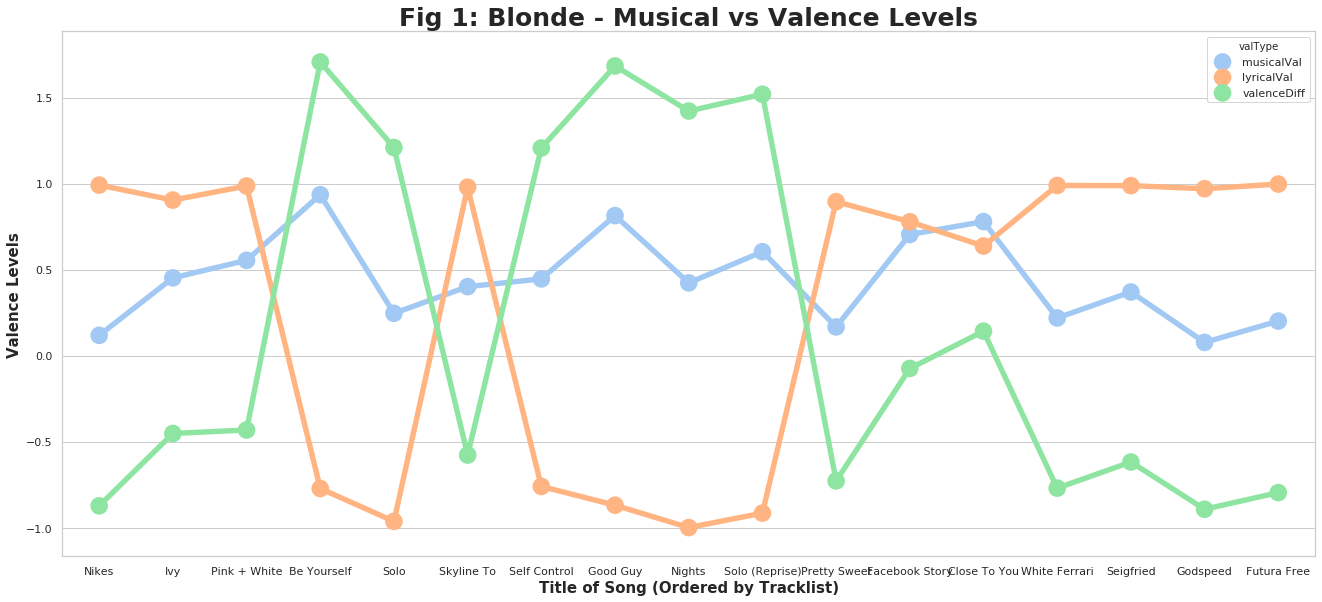

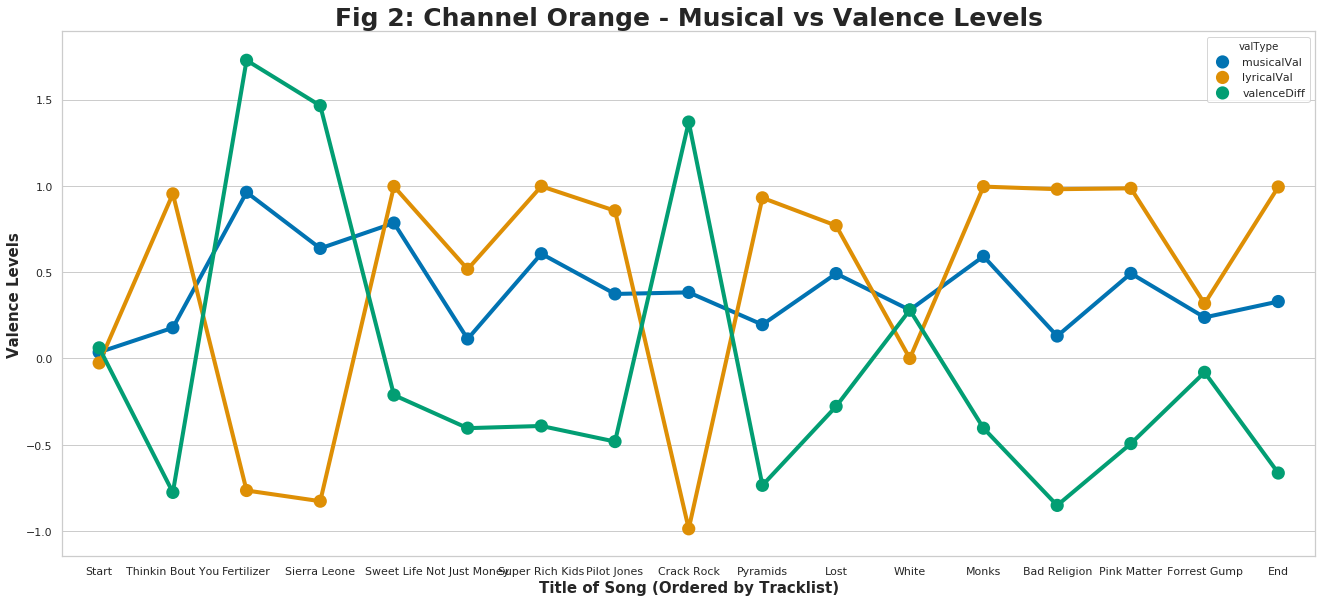

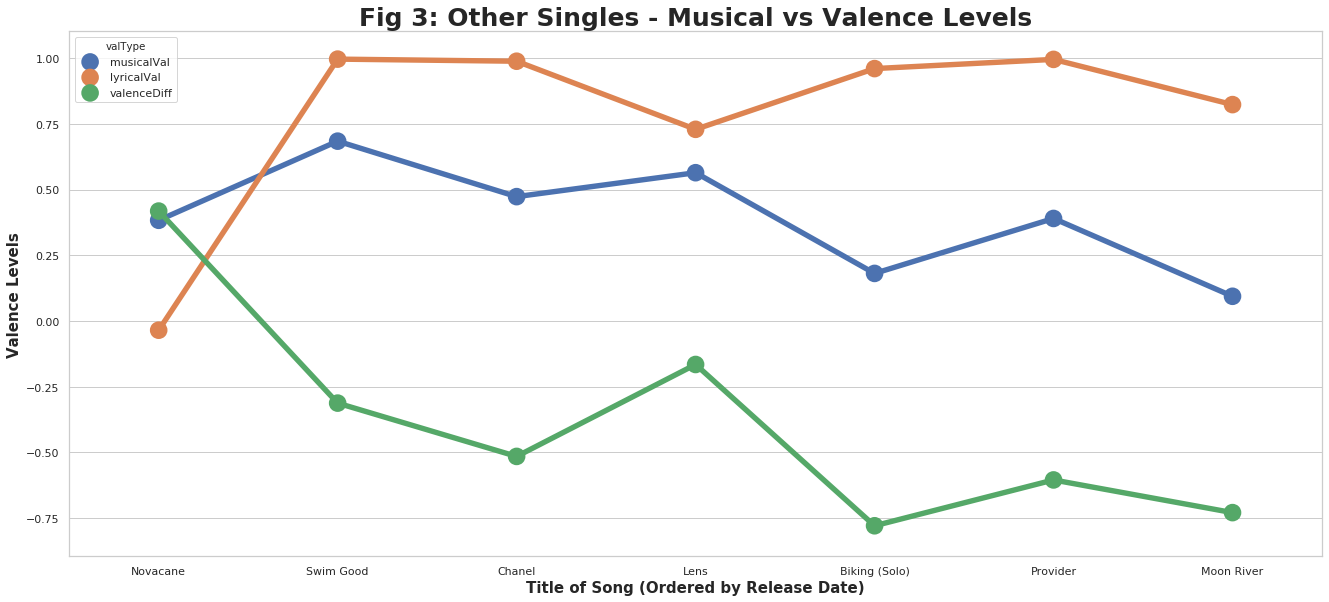

In [110]:
sns.set_style("whitegrid")

#Valence (Blonde)
plt.figure(figsize=(20, 9))
blonde_valence = sns.pointplot(x ='name', y = 'valence', hue = 'valType', data=final_blonde, 
                                palette = sns.color_palette('pastel'), scale = 2)
blonde_valence.set_ylabel("Valence Levels", weight = 'bold').set_fontsize('15')
blonde_valence.set_xlabel("Title of Song (Ordered by Tracklist)", weight = 'bold').set_fontsize('15')
blonde_valence.set_title("Fig 1: Blonde - Musical vs Valence Levels", weight='bold').set_fontsize('25')

#Valence (Channel Orange)
plt.figure(figsize=(20, 9))
orange_valence = sns.pointplot(x ='name', y = 'valence', hue = 'valType', data=final_orange, 
                                palette = sns.color_palette('colorblind'), scale = 1.5)
orange_valence.set_ylabel("Valence Levels", weight = 'bold').set_fontsize('15')
orange_valence.set_xlabel("Title of Song (Ordered by Tracklist)", weight = 'bold').set_fontsize('15')
orange_valence.set_title("Fig 2: Channel Orange - Musical vs Valence Levels", weight='bold').set_fontsize('25')

#THE SONG WHITE HAS NO LYRICAL VALENCE, SO IS BIASED FOR DIFFERENCE

#Valence (Others)
plt.figure(figsize=(20, 9))
other_valence = sns.pointplot(x ='name', y = 'valence', hue = 'valType', data=final_others, 
                                palette = sns.color_palette('deep'), scale = 2)
other_valence.set_ylabel("Valence Levels", weight = 'bold').set_fontsize('15')
other_valence.set_xlabel("Title of Song (Ordered by Release Date)", weight = 'bold').set_fontsize('15')
other_valence.set_title("Fig 3: Other Singles - Musical vs Valence Levels", weight='bold').set_fontsize('25')

Let's take the sum of these valenceTypes to see which album is technically more "positive" both lyircally and musically.

In [103]:
#final_blonde, final_orange, final_others (albums)
#valenceType: lyricalVal, valenceDiff, musicalVal

def calculate_valence_sum(valenceType, album):
    """ Calculates valenceSum for a valenceType and album"""
    total = 0
    df = album[album['valType'] == valenceType]
    for songVal in df['valence']:
        total+= songVal
    return total

calculate_valence_sum('lyricalVal', final_blonde)

4.835999999999999

In [102]:
calculate_valence_sum('lyricalVal', final_orange)

7.692999999999999

In [107]:
calculate_valence_sum('musicalVal', final_orange)

6.828999999999999

In [106]:
calculate_valence_sum('musicalVal', final_blonde)

7.51

In [109]:
calculate_valence_sum('lyricalVal', final_blonde) - calculate_valence_sum('lyricalVal', final_orange)

-2.8569999999999993

In summmary, my hypothesis that lyrically Frank Ocean's discography became more negative over time is true (where the difference among Blonde and Channel Orange is found above. However, musically Spotify describes Blonde to be 'happier' than Channel Orange. The opposite is true for the singles that were released, as shown by figure 3 above.

## Statistical Testing <a class="anchor" id="stat"></a>

#### F test or T-test(s) on VADER sentiments or Spotify attributes?

I thought about doing an F test or t-tests on songs among an album to see how much they differ based on the musical attributes provided by Spotify, but it doesn't seem as related to the current analysis.

I thought about doing a t-test on the computed valences by VADER, but it does not seem applicable to this case since each song is different from each other. I don't mind losing points for not including everything from the rubric.

Any tips or reccomendations on what statistical analysis I can do will help me a lot!\

#### Future models?

I thought about doing a classification model of using the valences and spotify attributes as features for classifying any song as positive or negative (but it's really biased on Frank's discrography and might not generalize well).

## Spotify Analysis<a class="anchor" id="spotify"></a>

Unfortunately I have no time to analyze the other attributes that Spotify provides, to be continued in a future update.

## Conclusion <a class="anchor" id="conc"></a>

Sentiment Analysis using VADER does a poor job in understanding the nuance of songwriting. The context is lost when we are removing stop words and analyzing each word individually for its sentiment (and not analyzing the sentiment with the surrounding words as phrases). We can see this is true when it scores "Super Rich Kids" as the most positive song in his discography, but an analysis found from Genius depicts a rather negative theme:

`The song elaborates on how a life full of material worth can never fulfill someone like love and happiness can. In the final verse, the character Frank is embodying falls (or jumps) from the roof he started his day on.`

As shown by all three figures, none of the valenceDifferences were 0, meaning that both the instrumentation described by Spotify does not match the computed VADER valence from the lyrics. I think by choosing Frank Ocean, this conclusion was to be expected; his production is seen as experimental, and thus does not follow what's "normal" for songwriting.

In the future, I hope to find a better lexicon that can rate phrases rather than individual words so the context is maintained when analyzing lyrics. Additionally, I hope I can learn more NLP methods so I can apply it on any artist's discography (luckily the script I wrote generalizes to any artist).